In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pprint

In [9]:
# CSV functions
def csv_to_dict(file):
    """
    read CSV file and create dict with key for each head containing a list of column entries for respective head
    
    :param file: path to CSV file to read
    :return: created dictionary
    """
    d = {}
    with open(file) as fin:
        reader = csv.reader(fin)
        headers = next(reader, None)
        for h in headers:
            d[h] = []
        for row in reader:
            for h, entry in zip(headers,row):
                d[h].append(entry)
    return d


def print_csv_dict(d):
    """
    print CSV dictionary in formatted way
    
    :param d: dict of CSV file to print
    :return:
    """
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(d)

In [36]:
# IMU data dict functions
def extract_acc(d):
    """
    extract acceleration vectors for IMU data run dict
    
    :param d: dict of CSV file of IMU data run
    :return: acc_x, acc_y, acc_z (numpy arrays)
    """
    acc_x = np.array(d['arx'], dtype='float32')
    acc_y = np.array(d['ary'], dtype='float32')
    acc_z = np.array(d['arz'], dtype='float32')
    return acc_x, acc_y, acc_z


def extract_corr_acc(d):
    """
    extract corrected acceleration vectors for IMU data run dict (subtracted gravity average)
    
    :param d: dict of CSV file of IMU data run
    :return: acc_cx, acc_cy, acc_cz (numpy arrays)
    """
    acc_cx = np.array(d['acx'], dtype='float32')
    acc_cy = np.array(d['acy'], dtype='float32')
    acc_cz = np.array(d['acz'], dtype='float32')
    return acc_cx, acc_cy, acc_cz

def norms(arrs):
    """
    compute euclidean norms of acceleration vectors for IMU data run dict
    
    :param arrs: list of numpy arrays to compute norm of (elementwise)
    :return: norm (numpy array)
    """
    s = np.zeros(arrs[0].shape)
    for arr in arrs:
        s += arr**2
    #norm = np.sqrt(np.sum([arr**2 for arr in arrs]))
    norm = np.sqrt(s)
    return norm

In [37]:
# read all IMU files
imu_data = {}
for run in range(4):
    run_name = 'run' + str(run + 1)
    imu_data_file = 'IMU_data/imu1_' + run_name + '_data.csv'
    run_dict = csv_to_dict(imu_data_file)
    imu_data[run_name] = run_dict

run1
Original norm MSE: 0.01394369
Additive MSE: 0.00092755
Mult MSE: 0.00090634
Add Mult MSE: 0.00090633
(10000, 1)


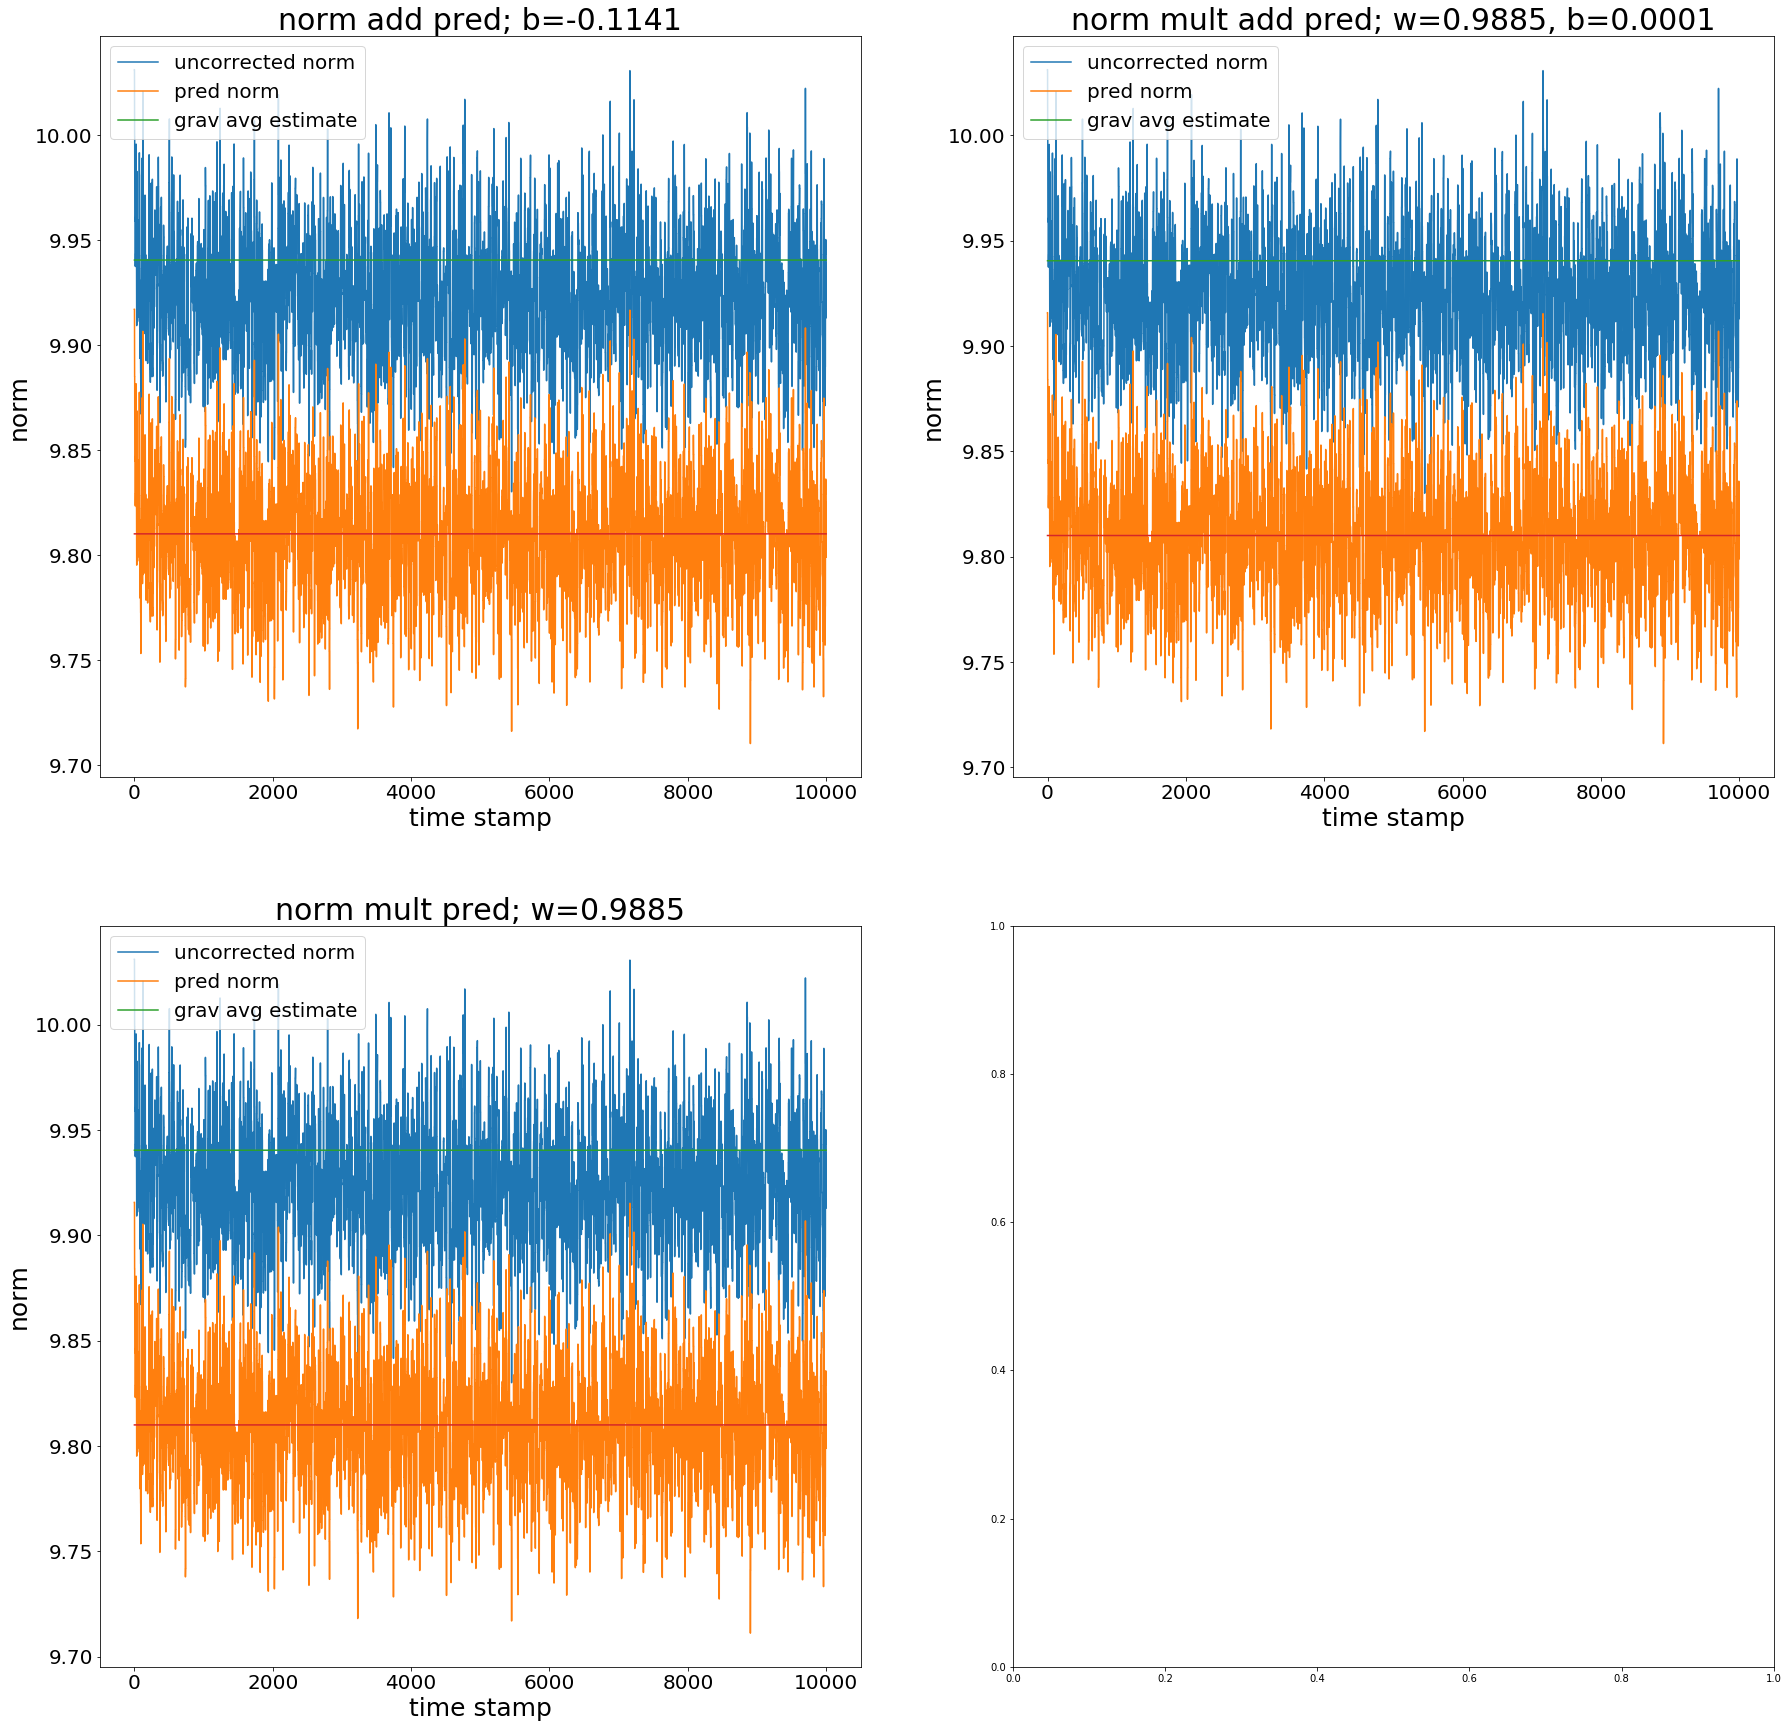

run2
Original norm MSE: 0.06300209
Additive MSE: 0.00075403
Mult MSE: 0.00071709
Add Mult MSE: 0.00071708
(10000, 1)


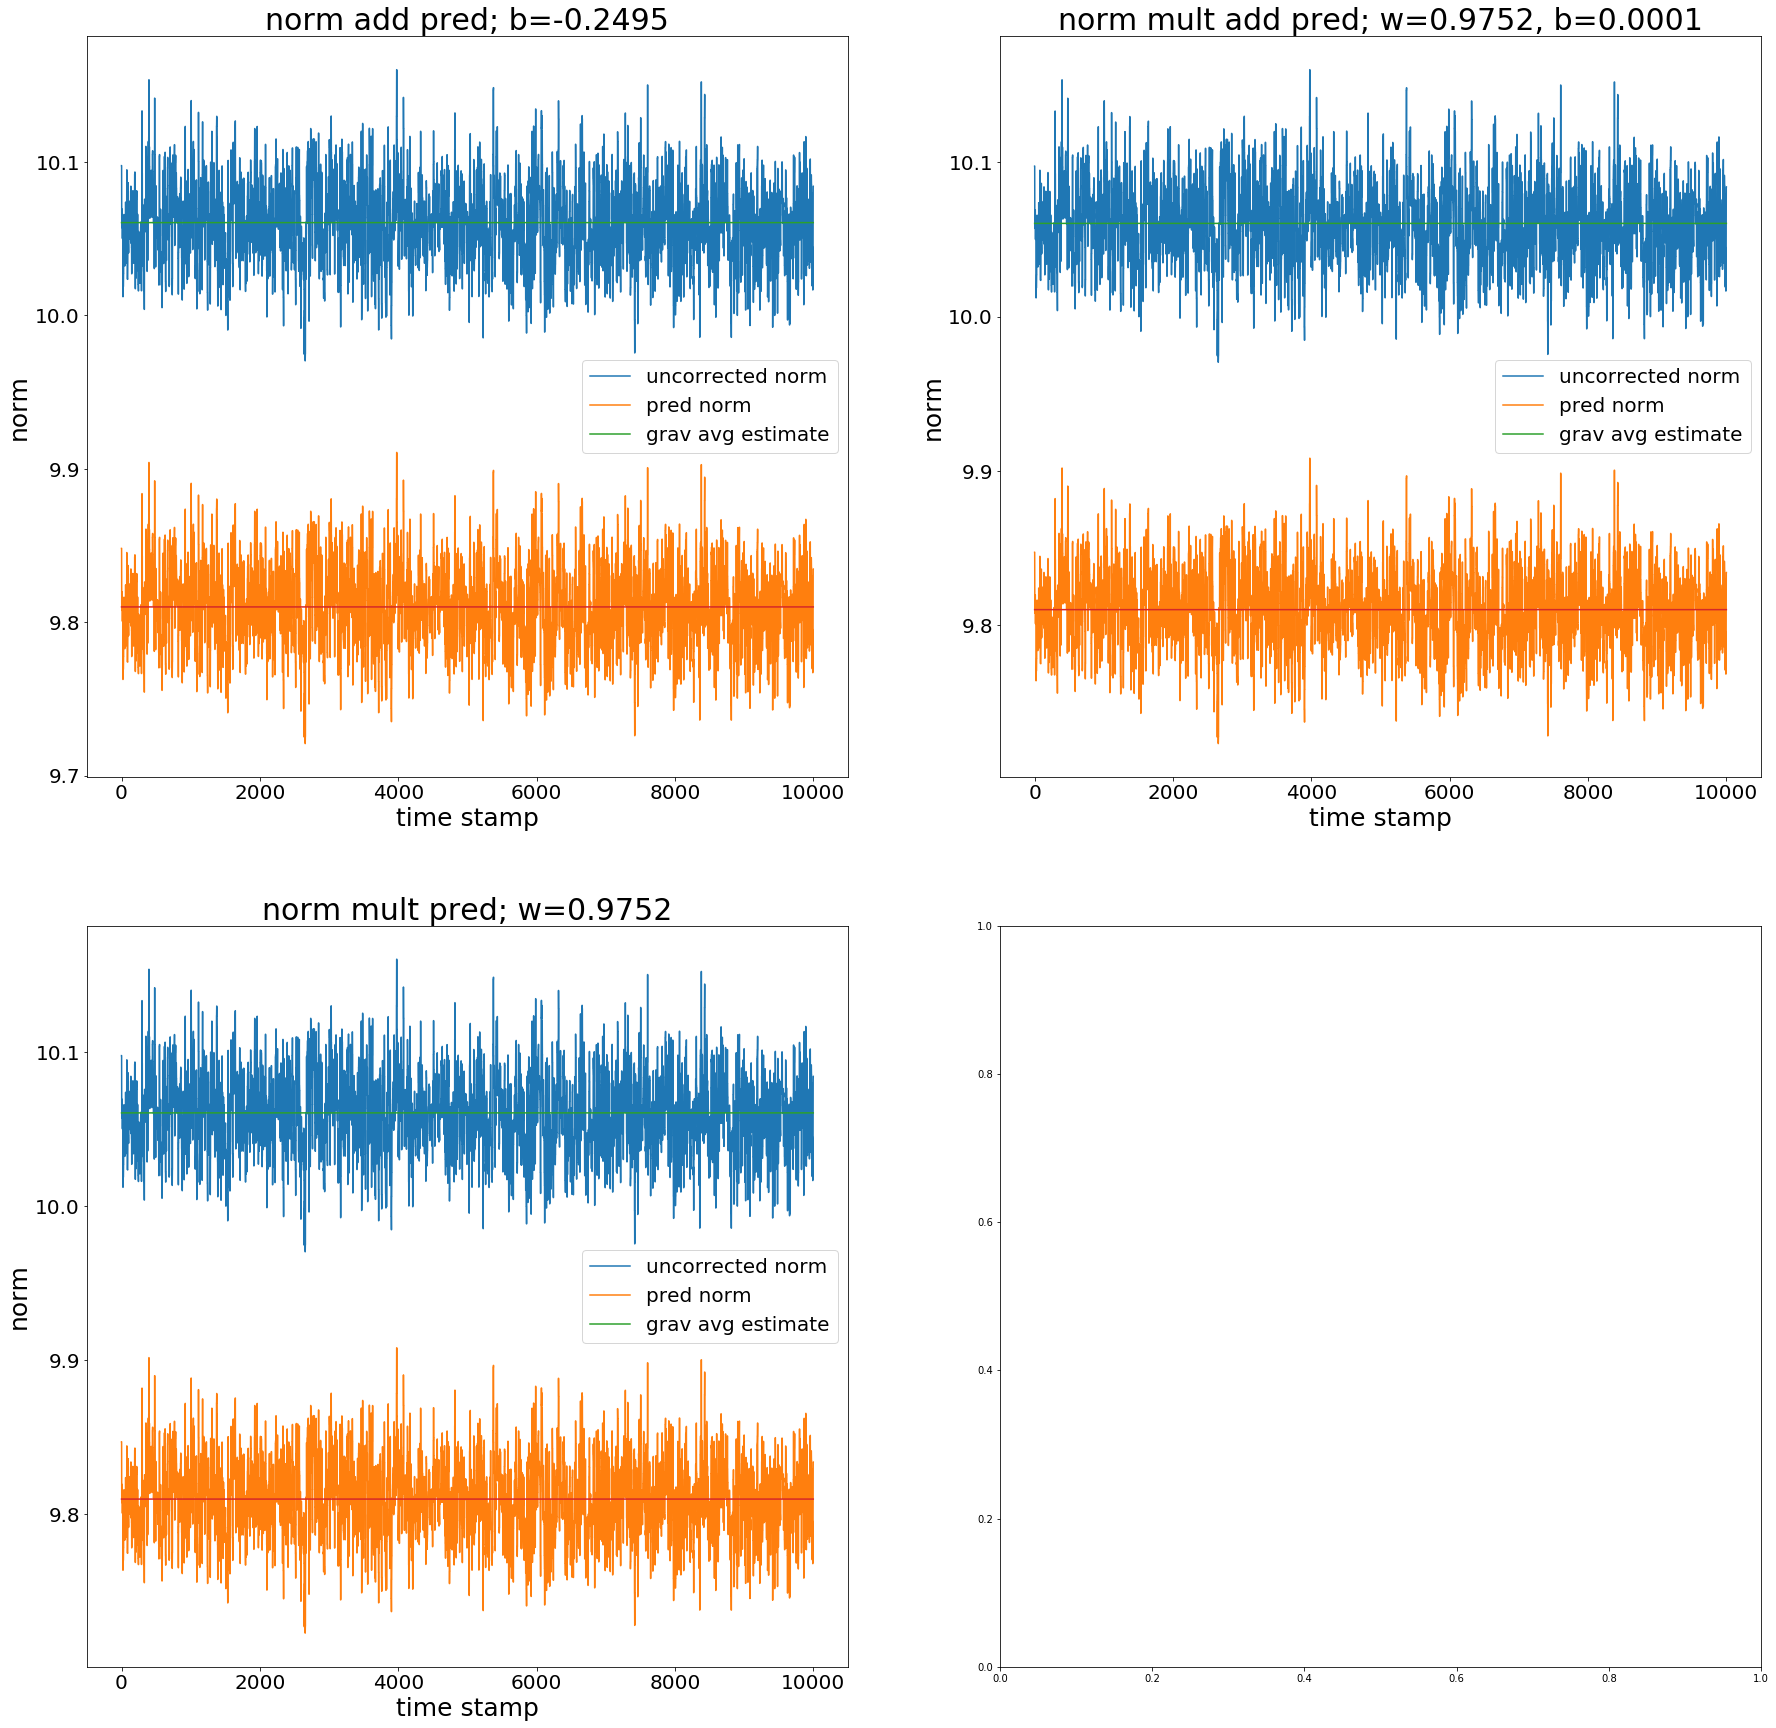

run3
Original norm MSE: 0.09025409
Additive MSE: 0.00045236
Mult MSE: 0.00042594
Add Mult MSE: 0.00042594
(10000, 1)


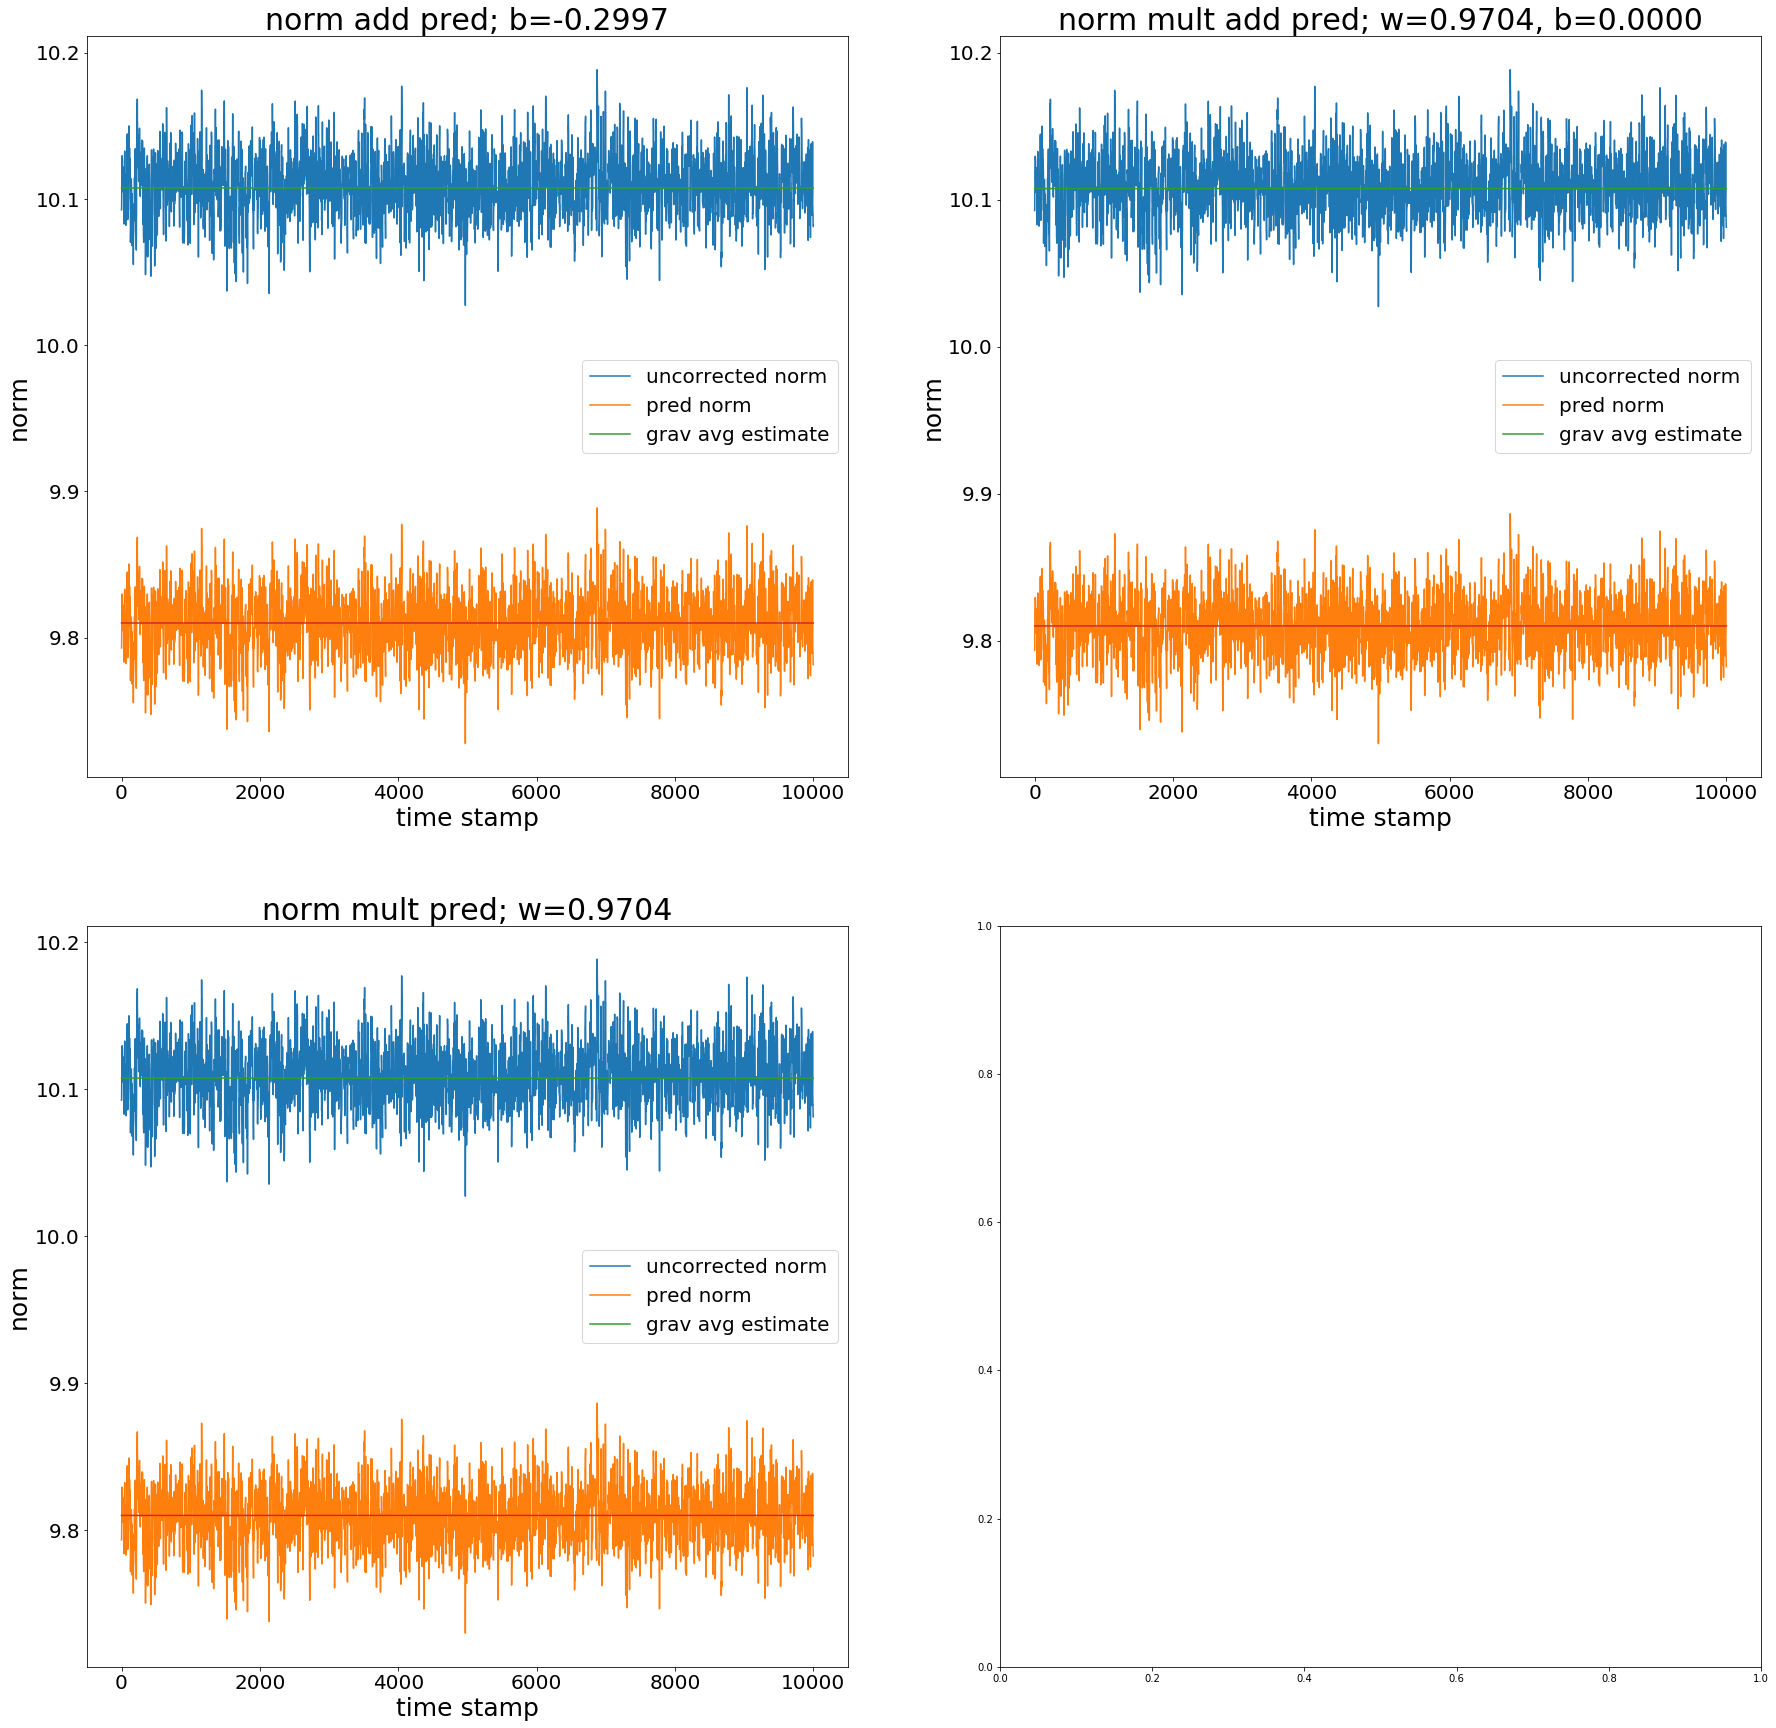

run4
Original norm MSE: 0.00064492
Additive MSE: 0.00060112
Mult MSE: 0.00060193
Add Mult MSE: 0.00060192
(10000, 1)


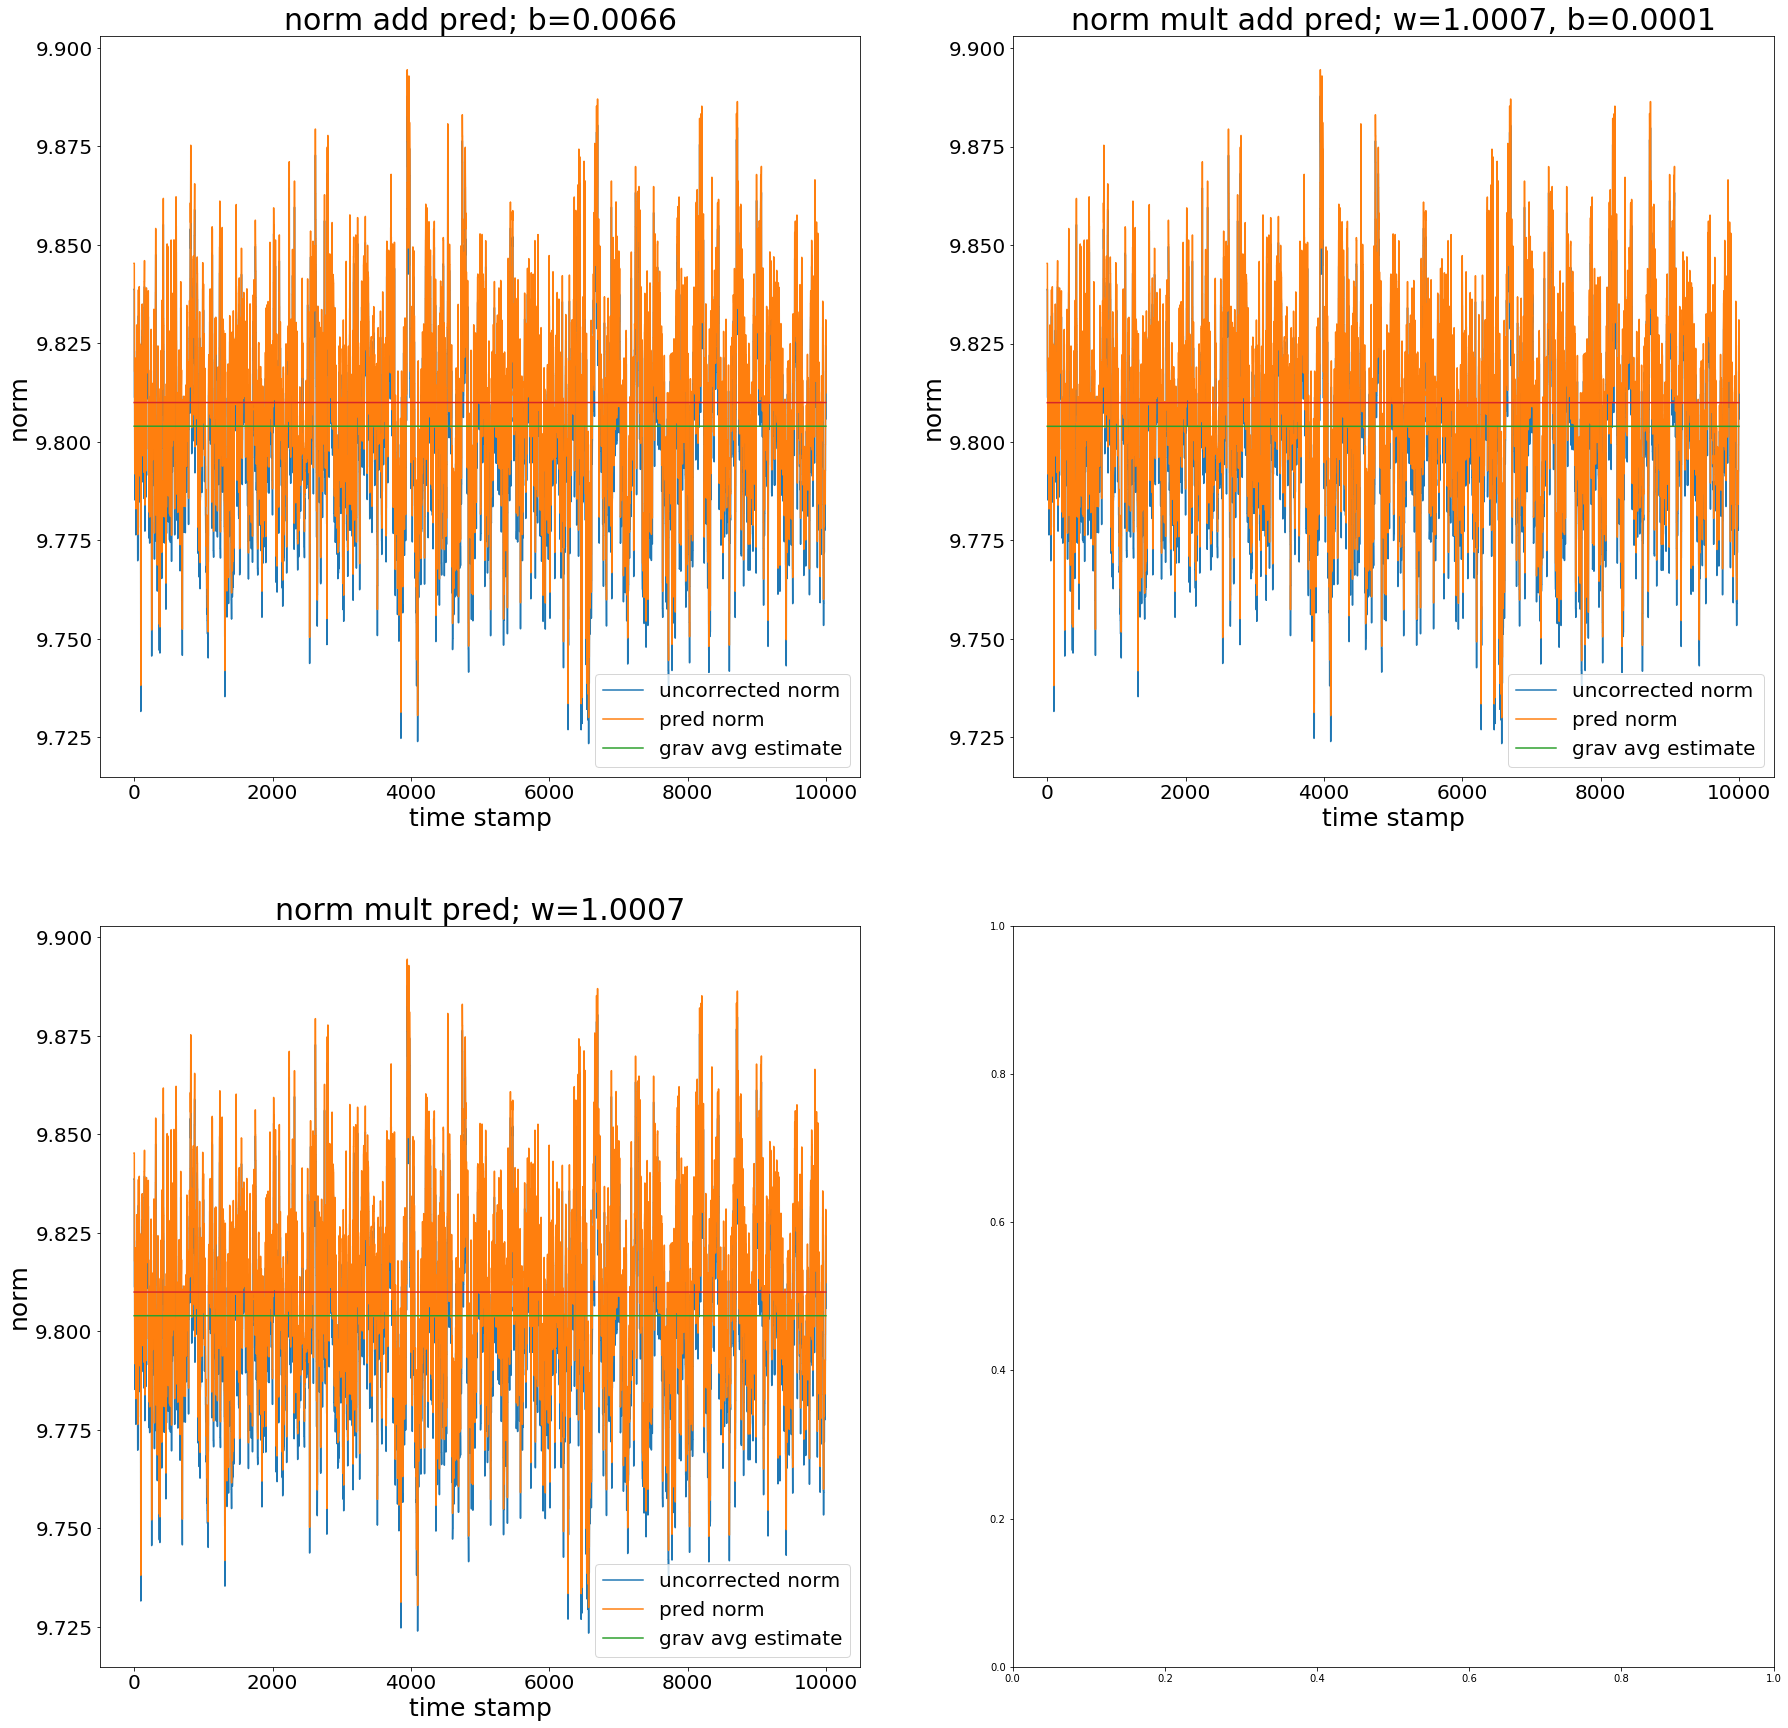

In [127]:
# prediction on norms
for run in imu_data:
    print(run)
    run_dict = imu_data[run]
    acc_x, acc_y, acc_z = extract_acc(run_dict)
    acc_cx, acc_cy, acc_cz = extract_corr_acc(run_dict)
    
    norm = norms([acc_x, acc_y, acc_z])
    target_norm = np.ones(norm.shape) * 9.81
    
    norm_x = np.expand_dims(norm, axis=-1)
    norm_y = np.expand_dims(target_norm, axis=-1)
    
    mse = ((norm_y - norm_x)**2).mean(axis=0)
    print("Original norm MSE: %.8f" % mse)
    
    # compute gravity estimates through average
    # WHY ARE THOSE VALUES NOT ALL EQUAL?
    grav_est_x = (acc_x - acc_cx)[0]
    grav_est_y = (acc_y - acc_cy)[0]
    grav_est_z = (acc_z - acc_cz)[0]
    norm_avg = np.sqrt(grav_est_x**2 + grav_est_y**2 + grav_est_z**2)
    norm_avg_v = np.ones(norm.shape) * norm_avg

    # optimise just additive bias to norm
    b_y = norm_y - norm_x
    b_x = np.ones(b_y.shape)
    b = np.linalg.lstsq(b_x, b_y, rcond=-1)[0]
    b_pred = norm_x + b
    b_mse = ((norm_y - b_pred)**2).mean(axis=0)
    print("Additive MSE: %.8f" % b_mse)
    
    # optimise weight as multiplative factor of norm
    w = np.linalg.lstsq(norm_x, norm_y, rcond=-1)[0]
    w_pred = norm_x * w
    w_mse = ((norm_y - w_pred)**2).mean(axis=0)
    print("Mult MSE: %.8f" % w_mse)
    
    # optimise bias as additive factor in addition to multiplative factor of norm
    w_bias_y = norm_y - norm_x * w
    w_bias_x = np.ones(w_bias_y.shape)
    w_b = np.linalg.lstsq(w_bias_x, w_bias_y, rcond=-1)[0]
    w_b_pred = norm_x * w + w_b
    w_b_mse = ((norm_y - w_b_pred)**2).mean(axis=0)
    print("Add Mult MSE: %.8f" % w_b_mse)
    
    bias_x = np.ones(bias_y.shape)
    norm_c = norms([acc_cx, acc_cy, acc_cz])
    
    # plotting
    f, axarr = plt.subplots(2, 2, figsize=(30,30))
    axarr[0, 0].plot(norm, label='uncorrected norm')
    axarr[0, 0].plot(b_pred, label='pred norm')
    axarr[0, 0].plot(norm_avg_v, label='grav avg estimate')
    axarr[0, 0].plot(target_norm)
    axarr[0, 0].set_title('norm add pred; b=%.4f' % b[0][0], fontsize=30)
    axarr[0, 0].set_xlabel('time stamp', fontsize=25)
    axarr[0, 0].set_ylabel('norm', fontsize=25)
    axarr[0, 0].tick_params(axis='both', which='major', labelsize=20)
    axarr[0, 0].legend(prop={'size': 20})
    
    axarr[1, 0].plot(norm, label='uncorrected norm')
    axarr[1, 0].plot(w_pred, label='pred norm')
    axarr[1, 0].plot(norm_avg_v, label='grav avg estimate')
    axarr[1, 0].plot(target_norm)
    axarr[1, 0].set_title('norm mult pred; w=%.4f' % w[0][0], fontsize=30)
    axarr[1, 0].set_xlabel('time stamp', fontsize=25)
    axarr[1, 0].set_ylabel('norm', fontsize=25)
    axarr[1, 0].tick_params(axis='both', which='major', labelsize=20)
    axarr[1, 0].legend(prop={'size': 20})
    
    axarr[0, 1].plot(norm, label='uncorrected norm')
    axarr[0, 1].plot(w_b_pred, label='pred norm')
    axarr[0, 1].plot(norm_avg_v, label='grav avg estimate')
    axarr[0, 1].plot(target_norm)
    axarr[0, 1].set_title('norm mult add pred; w=%.4f, b=%.4f' % (w[0][0], w_b[0][0]), fontsize=30)
    axarr[0, 1].set_xlabel('time stamp', fontsize=25)
    axarr[0, 1].set_ylabel('norm', fontsize=25)
    axarr[0, 1].tick_params(axis='both', which='major', labelsize=20)
    axarr[0, 1].legend(prop={'size': 20})

    #plt.subplots_adjust(wspace=0,hspace=1.0)
    plt.show()

run1
Mult MSE: 0.00090067
Add Mult MSE: 0.00090066


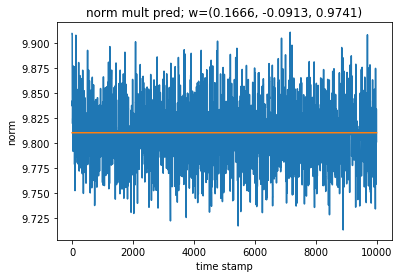

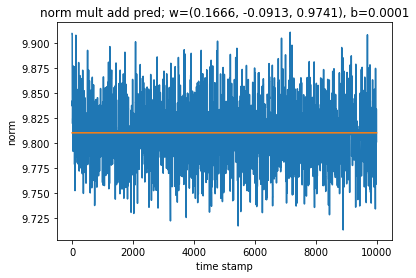

run2
Mult MSE: 0.00055772
Add Mult MSE: 0.00055771


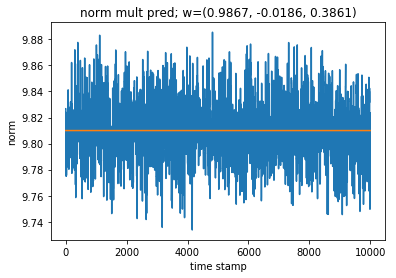

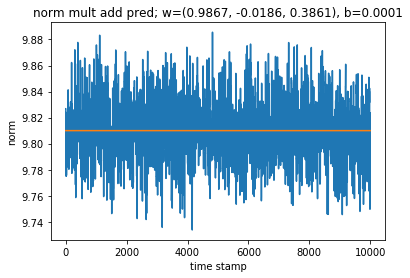

run3
Mult MSE: 0.00042570
Add Mult MSE: 0.00042570


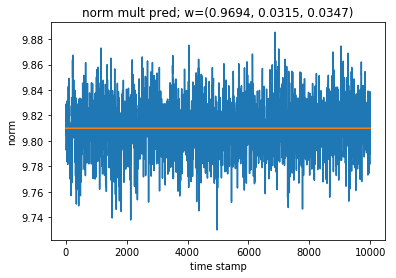

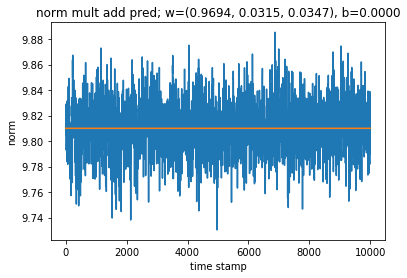

run4
Mult MSE: 0.00055546
Add Mult MSE: 0.00055545


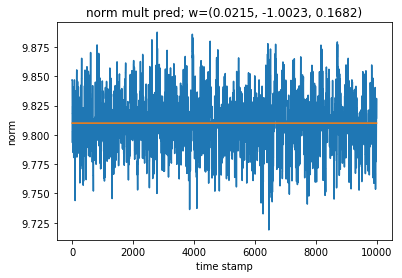

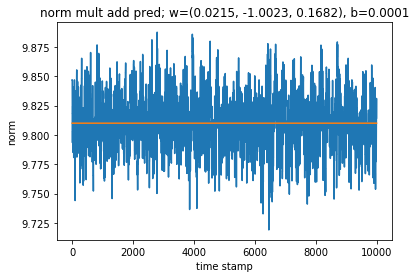

In [150]:
# prediction on accelerations
for run in imu_data:
    print(run)
    run_dict = imu_data[run]
    acc_x, acc_y, acc_z = extract_acc(run_dict)
    acc_cx, acc_cy, acc_cz = extract_corr_acc(run_dict)
    
    target_acc_z = np.ones(norm.shape) * 9.81
    
    acc = np.vstack([acc_x, acc_y, acc_z]).T
    target_acc_z = np.expand_dims(target_acc_z, axis=-1)

    # optimise just additive bias to norm
    #b_y = norm_y - norm_x
    #b_x = np.ones(b_y.shape)
    #b = np.linalg.lstsq(b_x, b_y, rcond=-1)[0]
    #b_pred = norm_x + b
    #b_mse = ((norm_y - b_pred)**2).mean(axis=0)
    #print("Additive MSE: %.8f" % b_mse)
    
    # optimise weight as multiplative factor of norm
    w = np.linalg.lstsq(acc, target_acc_z, rcond=-1)[0]
    w_pred = np.dot(acc, w)
    w_mse = ((target_acc_z - w_pred)**2).mean(axis=0)
    print("Mult MSE: %.8f" % w_mse)
    
    # optimise bias as additive factor in addition to multiplative factor of norm
    w_bias_y = target_acc_z - w_pred
    w_bias_x = np.ones(w_bias_y.shape)
    w_b = np.linalg.lstsq(w_bias_x, w_bias_y, rcond=-1)[0]
    w_b_pred = np.dot(acc, w) + w_b
    w_b_mse = ((target_acc_z - w_b_pred)**2).mean(axis=0)
    print("Add Mult MSE: %.8f" % w_b_mse)
        
    # plotting
    plt.figure(1)
    plt.plot(w_pred)
    plt.plot(target_acc_z)
    plt.title('norm mult pred; w=(%.4f, %.4f, %.4f)' % (w[0][0], w[1][0], w[2][0]))
    plt.xlabel('time stamp')
    plt.ylabel('norm')
    
    plt.figure(2)
    plt.plot(w_b_pred)
    plt.plot(target_acc_z)
    plt.title('norm mult add pred; w=(%.4f, %.4f, %.4f), b=%.4f' % (w[0][0], w[1][0], w[2][0], w_b[0][0]))
    plt.xlabel('time stamp')
    plt.ylabel('norm')
    plt.show()